In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env OPENROUTER_API_KEY=your_openrouter_api_key_here

env: OPENROUTER_API_KEY=your_openrouter_api_key_here


In [3]:
from openai import OpenAI
from os import getenv
import requests
import time

client = OpenAI(
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

def pass_through_llm(messages, model_name, get_usage=True):
    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=1,
        extra_body={
            "usage": {"include": True}
        }
    )
    usage_data = None
    if get_usage:
        # Use OpenRouter API to get detailed generation info
        url = "https://openrouter.ai/api/v1/generation"
        response_id = getattr(response, "id", None)
        if response_id is not None:
            time.sleep(.5)
            querystring = {"id": response_id}
            headers = {"Authorization": f"Bearer {getenv('OPENROUTER_API_KEY')}"}
            api_response = requests.get(url, headers=headers, params=querystring)
            if api_response.status_code == 200:
                data = api_response.json().get("data", {})
                # Safely get prompt and completion tokens, defaulting to 0 if not found
                prompt_tokens = data.get("native_tokens_prompt")
                if prompt_tokens is None:
                    prompt_tokens = data.get("tokens_prompt", 0)
                completion_tokens = data.get("native_tokens_completion")
                if completion_tokens is None:
                    completion_tokens = data.get("tokens_completion", 0)
                usage_data = dict(
                    completion_tokens=completion_tokens,
                    prompt_tokens=prompt_tokens,
                    total_tokens=(prompt_tokens or 0) + (completion_tokens or 0),
                    cost=data.get("usage", data.get("total_cost")),
                    model=data.get("model"),
                    cached_tokens_read=data.get("native_tokens_cached", 0),
                    reasoning_tokens=data.get("native_tokens_reasoning", 0),
                    latency=data.get("latency"),
                    generation_time=data.get("generation_time"),
                    throughput=(completion_tokens / (data.get("generation_time", 1) / 1000.0) if data.get("generation_time") else None)
                )
            else:
                # fallback to response.usage if API call fails
                usage_data = dict(
                    completion_tokens=getattr(response.usage, "completion_tokens", None),
                    prompt_tokens=getattr(response.usage, "prompt_tokens", None),
                    total_tokens=getattr(response.usage, "total_tokens", None),
                    cost=getattr(response.usage, "cost", None),
                    model=getattr(response, "model", None),
                    cached_tokens_read=getattr(getattr(response.usage, "prompt_tokens_details", {}), "cached_tokens", 0),
                    reasoning_tokens=getattr(getattr(response.usage, "completion_tokens_details", {}), "reasoning_tokens", 0),
                    latency=None,
                    generation_time=None,
                    throughput=None
                )
        else:
            # fallback to response.usage if no id
            usage_data = dict(
                completion_tokens=getattr(response.usage, "completion_tokens", None),
                prompt_tokens=getattr(response.usage, "prompt_tokens", None),
                total_tokens=getattr(response.usage, "total_tokens", None),
                cost=getattr(response.usage, "cost", None),
                model=getattr(response, "model", None),
                cached_tokens_read=getattr(getattr(response.usage, "prompt_tokens_details", {}), "cached_tokens", 0),
                reasoning_tokens=getattr(getattr(response.usage, "completion_tokens_details", {}), "reasoning_tokens", 0),
                latency=None,
                generation_time=None,
                throughput=None
            )
    else:
        usage_data = None
    return response, usage_data

In [4]:
response, parsed_usage = pass_through_llm(
    [
        {"role": "system", "content": "You are a helpful assistant " * 300},
        {"role": "user", "content": "What is 1+1? think first"}
    ],
    "openai/o3"
)

In [5]:
parsed_usage

{'completion_tokens': 83,
 'prompt_tokens': 1520,
 'total_tokens': 1603,
 'cost': 0.00014816,
 'model': 'openai/o3-2025-04-16',
 'cached_tokens_read': 0,
 'reasoning_tokens': 64,
 'latency': 4690,
 'generation_time': 7971,
 'throughput': 10.4127462049931}

In [9]:
from datasets import load_dataset

trivia = load_dataset("llamastack/simpleqa", split="train")

trivia

Dataset({
    features: ['metadata', 'input_query', 'expected_answer', 'chat_completion_input'],
    num_rows: 4326
})

In [10]:
trivia[0]

{'metadata': "{'topic': 'Science and technology', 'answer_type': 'Person', 'urls': ['https://en.wikipedia.org/wiki/IEEE_Frank_Rosenblatt_Award', 'https://ieeexplore.ieee.org/author/37271220500', 'https://en.wikipedia.org/wiki/IEEE_Frank_Rosenblatt_Award', 'https://www.nxtbook.com/nxtbooks/ieee/awards_2010/index.php?startid=21#/p/20']}",
 'input_query': 'Who received the IEEE Frank Rosenblatt Award in 2010?',
 'expected_answer': 'Michio Sugeno',
 'chat_completion_input': '[{"role": "user", "content": "Who received the IEEE Frank Rosenblatt Award in 2010?"}]'}

In [11]:
def format_trivia_qa(example):
    return {"formatted_qa": f"Question: {example['input_query']} || Answer: {example['expected_answer']}"}

trivia = trivia.map(format_trivia_qa).shuffle()

trivia['formatted_qa'][0]

'Question: In which episode and season of "The Jeffersons" is Charlie\'s secret revealed? || Answer: Episode 17, Season 11, "A Secret in the Back Room"'

# Testing Prompt Caches

In [8]:
import random

num_trivia_questions_to_use = 3500

trivia_questions_to_use = random.sample(list(trivia['formatted_qa']), num_trivia_questions_to_use)

SYSTEM_PROMPT = f'''\
You will be asked trivia questions from the given dataset and your job is to answer them.

You may only use the information provided in the trivia questions + answers below.

Trivia questions + answers:
{"\n".join(trivia_questions_to_use)}
'''

parsed_results = []

In [9]:
from tqdm import tqdm
k = 50  # number of questions to ask after the trivia questions

for model_name in [
    "openai/gpt-4.1-mini", "openai/gpt-4.1", "openai/gpt-4.1-nano", 
    "openai/o4-mini"
    ]:

    for i in tqdm(range(num_trivia_questions_to_use, num_trivia_questions_to_use + k), desc=model_name):
        actual_answer = trivia['expected_answer'][i]
        start_time = time.time()
        response, parsed_usage = pass_through_llm(
            [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": trivia_questions_to_use[0].split("||")[0]}  # we don't actually care about the answer here, we just want to see if the cache is hit or not
            ],
            model_name
        )
        end_time = time.time()
        parsed_usage['ai_answer'] = response.choices[0].message.content
        parsed_usage['actual_answer'] = actual_answer
        parsed_usage['time_taken'] = end_time - start_time
        parsed_usage['model'] = model_name
        parsed_usage['question_id'] = i - num_trivia_questions_to_use
        parsed_results.append(parsed_usage)


openai/o4-mini: 100%|██████████| 50/50 [07:48<00:00,  9.37s/it]


In [10]:
from pandas import DataFrame

df = DataFrame(parsed_results)
df.head()

,completion_tokens,prompt_tokens,total_tokens,cost,model,cached_tokens_read,reasoning_tokens,latency,generation_time,throughput,ai_answer,actual_answer,time_taken,question_id
0,2,113770,113772,0.001820,openai/gpt-4.1-mini,0,0,5286,8,250.000000,1926,"November 1, 2018",6.963451,0
1,2,113770,113772,0.000456,openai/gpt-4.1-mini,113664,0,1841,2,1000.000000,1926,1954,2.900003,1
2,2,113770,113772,0.001820,openai/gpt-4.1-mini,0,0,6031,17,117.647059,1926,Fleur d’ajonc,7.178856,2
3,2,113770,113772,0.001820,openai/gpt-4.1-mini,0,0,4573,9,222.222222,1926,"September 14, 2011",5.991955,3
4,2,113770,113772,0.001820,openai/gpt-4.1-mini,0,0,5855,31,64.516129,1926,"""She Even Woke Me Up to Say Goodbye""",7.062970,4


In [11]:
df['cache_hit'] = df['cached_tokens_read'] > 300


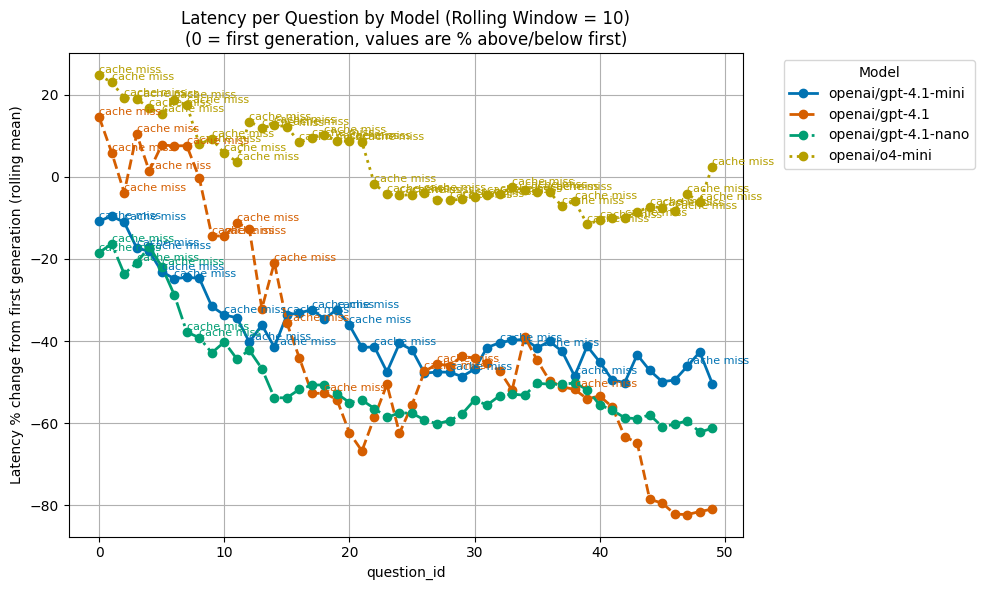

In [96]:
import matplotlib.pyplot as plt
import itertools

plt.figure(figsize=(10, 6))

# Use a colorblind-friendly palette and a set of line styles
colorblind_colors = [
    "#0072B2",  # Blue
    "#D55E00",  # Vermillion
    "#009E73",  # Green
    "#B59F00",  # Darker Yellow
    "#CC79A7",  # Purple
    "#56B4E9",  # Sky Blue
    "#E69F00",  # Orange
    "#000000",  # Black
]
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 1)), (0, (3, 5, 1, 5))]

# Create iterators for colors and line styles
color_cycle = itertools.cycle(colorblind_colors)
style_cycle = itertools.cycle(line_styles)

model_to_color = {}
model_to_style = {}

for model_name in df['model'].unique():
    color = next(color_cycle)
    style = next(style_cycle)
    model_to_color[model_name] = color
    model_to_style[model_name] = style

window = 10  # Rolling window size for smoothing

for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name].copy()
    # Sort by question_id to ensure rolling is correct
    model_df = model_df.sort_values('question_id')
    # Get the first latency value for this model
    first_latency = model_df['latency'].iloc[0]
    # Compute percent change from the first latency, so first value is 0, others are % above/below
    model_df['latency_pct_change'] = (model_df['latency'] - first_latency) / first_latency * 100
    # Compute rolling mean for percent change
    model_df['latency_pct_change_rolling'] = model_df['latency_pct_change'].rolling(window=window, min_periods=1, center=True).mean()
    plt.plot(
        model_df['question_id'],
        model_df['latency_pct_change_rolling'],
        marker='o',
        label=model_name,
        color=model_to_color[model_name],
        linestyle=model_to_style[model_name],
        linewidth=2
    )
    # Add label for each dot (optional: you may want to only label the original points, not the smoothed line)
    for idx, row in model_df.iterrows():
        label = "" if row['cache_hit'] else "cache miss"
        plt.text(
            row['question_id'],
            row['latency_pct_change_rolling'],
            label,
            fontsize=8,
            ha='left',
            va='bottom',
            color=model_to_color[model_name]
        )

plt.xlabel('question_id')
plt.ylabel('Latency % change from first generation (rolling mean)')
plt.title(f'Latency per Question by Model (Rolling Window = {window})\n(0 = first generation, values are % above/below first)')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('latency_per_question_by_model.png', dpi=300)
plt.show()


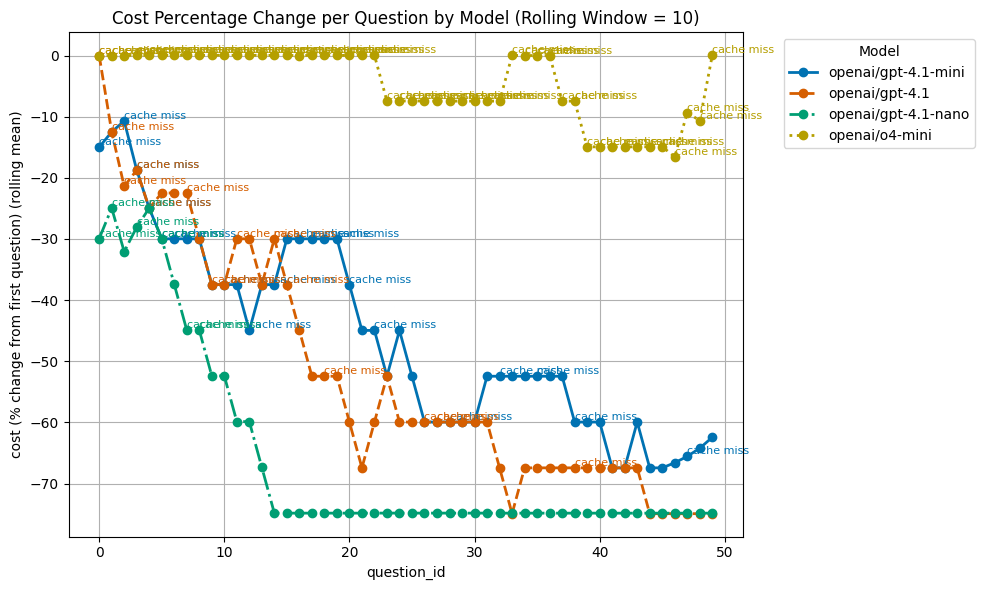

In [97]:
import matplotlib.pyplot as plt
import itertools

plt.figure(figsize=(10, 6))

# Use a colorblind-friendly palette and a set of line styles
colorblind_colors = [
    "#0072B2",  # Blue
    "#D55E00",  # Vermillion
    "#009E73",  # Green
    "#B59F00",  # Darker Yellow
    "#CC79A7",  # Purple
    "#56B4E9",  # Sky Blue
    "#E69F00",  # Orange
    "#000000",  # Black
]
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 1)), (0, (3, 5, 1, 5))]

# Create iterators for colors and line styles
color_cycle = itertools.cycle(colorblind_colors)
style_cycle = itertools.cycle(line_styles)

model_to_color = {}
model_to_style = {}

for model_name in df['model'].unique():
    color = next(color_cycle)
    style = next(style_cycle)
    model_to_color[model_name] = color
    model_to_style[model_name] = style

window = 10  # Rolling window size for smoothing

for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name].copy()
    # Sort by question_id to ensure rolling is correct
    model_df = model_df.sort_values('question_id')
    # Calculate percentage change from the first row's cost for this model
    first_cost = model_df['cost'].iloc[0]
    # Avoid division by zero
    if first_cost == 0:
        pct_change = model_df['cost'] * 0
    else:
        pct_change = (model_df['cost'] - first_cost) / first_cost * 100
    # Compute rolling mean for percentage change
    pct_change_rolling = pct_change.rolling(window=window, min_periods=1, center=True).mean()
    plt.plot(
        model_df['question_id'],
        pct_change_rolling,
        marker='o',
        label=model_name,
        color=model_to_color[model_name],
        linestyle=model_to_style[model_name],
        linewidth=2
    )
    # Add label for each dot (optional: you may want to only label the original points, not the smoothed line)
    for idx, (qid, pct, row) in enumerate(zip(model_df['question_id'], pct_change_rolling, model_df.itertuples())):
        label = "" if getattr(row, 'cache_hit', False) else "cache miss"
        plt.text(
            qid,
            pct,
            label,
            fontsize=8,
            ha='left',
            va='bottom',
            color=model_to_color[model_name]
        )

plt.xlabel('question_id')
plt.ylabel('cost (% change from first question) (rolling mean)')
plt.title(f'Cost Percentage Change per Question by Model (Rolling Window = {window})')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('cost_percentage_change_per_question_by_model.png', dpi=300)
plt.show()


                         latency                   cost          
cache_hit                  False        True      False     True 
model                                                            
openai/gpt-4.1       8561.200000  2175.171429  0.009102  0.002282
openai/gpt-4.1-mini  4974.000000  2230.838710  0.001820  0.000456
openai/gpt-4.1-nano  2179.833333   927.909091  0.000455  0.000115
openai/o4-mini       7167.765957  4035.000000  0.005020  0.001270


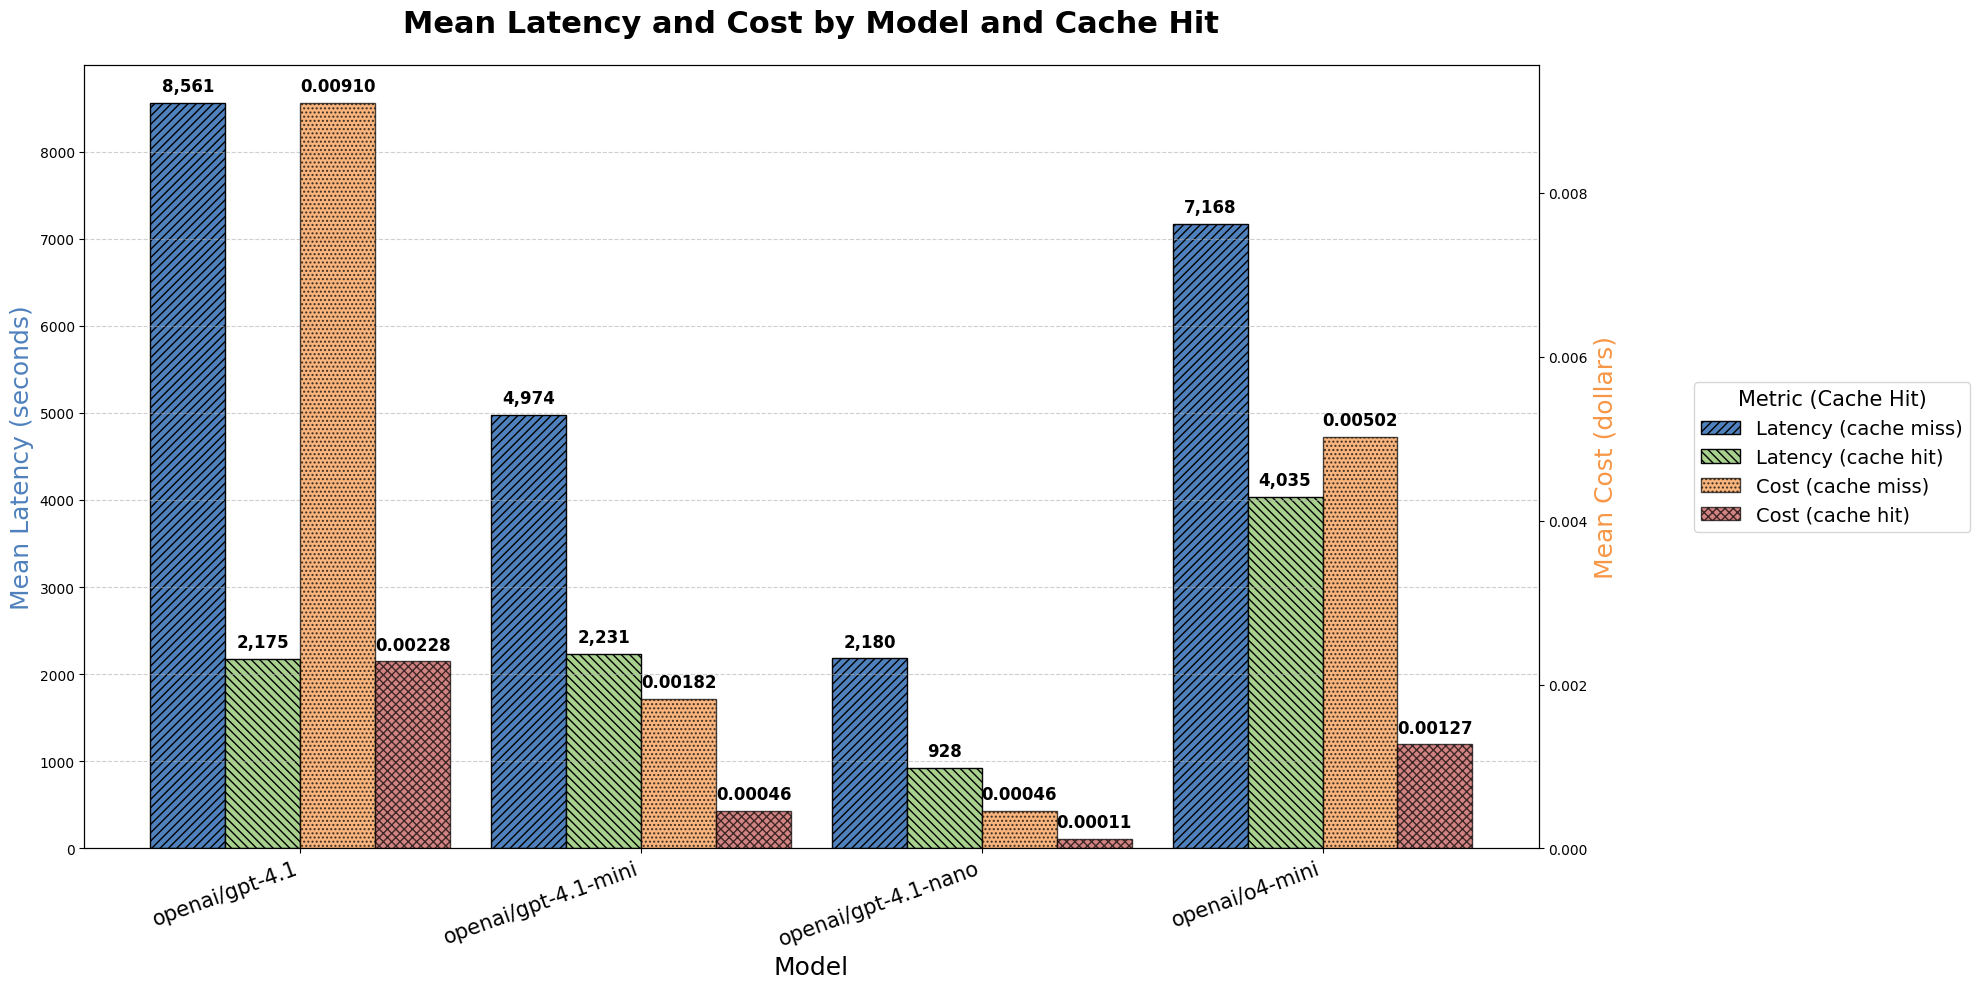

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
grouped = df.groupby(['model', 'cache_hit'], observed=True).agg({'latency': 'mean', 'cost': 'mean'}).unstack()
print(grouped)

# Handle missing cache_hit values (if any model lacks True/False, fill with 0)
for metric in ['latency', 'cost']:
    for hit in [False, True]:
        if (metric, hit) not in grouped.columns:
            grouped[(metric, hit)] = 0
grouped = grouped.sort_index(axis=1)  # Ensure column order

# Set up figure and axes (add second y axis for cost)
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # Second y axis for cost

# Custom colors for clarity and accessibility
colors = {
    ('latency', False): '#4F81BD',  # blue
    ('latency', True): '#A9D18E',   # green
    ('cost', False): '#F79646',     # orange
    ('cost', True): '#C0504D',      # red
}

# Hatch patterns for colorblind accessibility
hatches = {
    ('latency', False): '////',   # blue, cache miss
    ('latency', True): '\\\\\\\\', # green, cache hit
    ('cost', False): '....',      # orange, cache miss
    ('cost', True): 'xxxx',       # red, cache hit
}

# Bar width and positions
bar_width = 0.22
x = np.arange(len(grouped.index))

# Get values, filling NaN with 0 for plotting
latency_false = grouped['latency', False].fillna(0)
latency_true = grouped['latency', True].fillna(0)
cost_false = grouped['cost', False].fillna(0)
cost_true = grouped['cost', True].fillna(0)

# Plot latency bars on ax1 (left y axis) with hatches
latency_bars = ax1.bar(
    x - 1.5*bar_width, latency_false, bar_width,
    label='Latency (cache miss)',
    color=colors[('latency', False)],
    edgecolor='black',
    hatch=hatches[('latency', False)]
)
latency_bars2 = ax1.bar(
    x - 0.5*bar_width, latency_true, bar_width,
    label='Latency (cache hit)',
    color=colors[('latency', True)],
    edgecolor='black',
    hatch=hatches[('latency', True)]
)

# Plot cost bars on ax2 (right y axis) with hatches
cost_bars = ax2.bar(
    x + 0.5*bar_width, cost_false, bar_width,
    label='Cost (cache miss)',
    color=colors[('cost', False)],
    edgecolor='black',
    alpha=0.7,
    hatch=hatches[('cost', False)]
)
cost_bars2 = ax2.bar(
    x + 1.5*bar_width, cost_true, bar_width,
    label='Cost (cache hit)',
    color=colors[('cost', True)],
    edgecolor='black',
    alpha=0.7,
    hatch=hatches[('cost', True)]
)

# X-axis labels and ticks
ax1.set_xticks(x)
ax1.set_xticklabels(grouped.index, rotation=20, ha='right', fontsize=15)

# Titles and labels (font size increased)
ax1.set_title('Mean Latency and Cost by Model and Cache Hit', fontsize=22, fontweight='bold', pad=24)
ax1.set_xlabel('Model', fontsize=18)
ax1.set_ylabel('Mean Latency (seconds)', fontsize=18, color='#4F81BD')
ax2.set_ylabel('Mean Cost (dollars)', fontsize=18, color='#F79646')

# Custom legend (combine both axes)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
by_label = dict(zip(labels1 + labels2, handles1 + handles2))

# Put legend outside
# Use bbox_to_anchor to place the legend outside the plot area on the right
ax1.legend(
    by_label.values(),
    by_label.keys(),
    title='Metric (Cache Hit)',
    fontsize=14,
    title_fontsize=15,
    loc='center left',
    bbox_to_anchor=(1.1, 0.5),
    frameon=True
)

# Add value labels for clarity
def autolabel(ax, bars, orig_values, fmt="{:.0f}", y_offset_frac=0.01):
    """
    Place value labels just above the bar, using a y-offset that is a fraction of the y-axis range.
    This prevents labels from being placed too high when the bar values are small compared to the axis range.
    """
    y_min, y_max = ax.get_ylim()
    y_offset = (y_max - y_min) * y_offset_frac
    for bar, orig in zip(bars, orig_values):
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                height + y_offset,
                fmt.format(orig),
                ha='center', va='bottom',
                fontsize=12, color='black', fontweight='bold'
            )

# Show original values as labels
autolabel(ax1, latency_bars, latency_false, fmt="{:,.0f}")
autolabel(ax1, latency_bars2, latency_true, fmt="{:,.0f}")
autolabel(ax2, cost_bars, cost_false, fmt="{:.5f}", y_offset_frac=0.01)
autolabel(ax2, cost_bars2, cost_true, fmt="{:.5f}", y_offset_frac=0.01)

# Grid and layout
ax1.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('mean_latency_and_cost_by_model_and_cache_hit.png', dpi=300)
plt.show()

# Needle in the Haystack

In [ ]:
more_trivia = load_dataset("LM-Polygraph/triviaqa", split="continutation")

In [12]:
num_trivia_questions_to_use = 10

trivia_questions_to_use = trivia['formatted_qa'][:num_trivia_questions_to_use]

random_fact = "When was Sinan Ozdemir born?"
random_fact_answer = "October 17th, 1991"

formatted_random_fact = f"Question: {random_fact} || Answer: {random_fact_answer}"

insert_random_fact_at_newline_index = 1
trivia_questions_to_use.insert(insert_random_fact_at_newline_index, formatted_random_fact)


SYSTEM_PROMPT = f'''\
You will be asked trivia questions from the given dataset and your job is to answer them.

You may only use the information provided in the trivia questions + answers below. Answer the question as closely as possible to the answer provided.

Trivia questions + answers:
{"\n".join(trivia_questions_to_use)}
'''

In [13]:
print(SYSTEM_PROMPT)

You will be asked trivia questions from the given dataset and your job is to answer them.

You may only use the information provided in the trivia questions + answers below. Answer the question as closely as possible to the answer provided.

Trivia questions + answers:
Question: In which episode and season of "The Jeffersons" is Charlie's secret revealed? || Answer: Episode 17, Season 11, "A Secret in the Back Room"
Question: When was Sinan Ozdemir born? || Answer: October 17th, 1991
Question: In what year was American music producer George Avakian appointed as head of the international department at Columbia Records? || Answer: 1948.
Question: On October 27, 2016, Dr. Sanduk Ruit received what award from the Asia Society for bringing the gifts of sight and a productive life to those most in need? || Answer: Game Changer Award
Question: What's the DOI of the paper 'Towards an Explanation of the Syntax of West Germanic Particle Verbs: A Cognitive-Pragmatic View' by Thomas Berg? || Answe

In [14]:
def generate_system_prompt_for_needle_in_haystack(trivia_questions_to_use, formatted_random_fact, insert_random_fact_at_newline_index):

    trivia_questions_to_use.insert(insert_random_fact_at_newline_index, formatted_random_fact)

    SYSTEM_PROMPT = f'''\
    You will be asked trivia questions from the given dataset and your job is to answer them.

    You may only use the information provided in the trivia questions + answers below. Answer the question as closely as possible to the answer provided.

    Trivia questions + answers:
    {"\n".join(trivia_questions_to_use)}
    '''
    return SYSTEM_PROMPT

In [15]:
question_variants = [
    "Do you know when Sinan Ozdemir was born?",
    "When was Sinan Ozdemir born?",
    "Can you tell me the birthdate of Sinan Ozdemir?",
    "What is the birthdate of Sinan Ozdemir?",
    "Do you know when Sinan Ozdemir was born?",
    "Tell me when Sinan Ozdemir was born."
]

parsed_nith_results = []


In [156]:
from tqdm import tqdm
from random import randint, choice
import numpy as np

_times = 100

random_fact = "When was Sinan Ozdemir born?"
random_fact_answer = "October 17th, 1991"
formatted_random_fact = f"Question: {random_fact} || Answer: {random_fact_answer}"

model_names = [
    # "x-ai/grok-3-mini"
    # "openai/gpt-4.1-nano", 
    # "qwen/qwen3-32b-04-28",
    "google/gemini-2.5-flash-lite-preview-06-17"
    ]

percentiles = np.linspace(20, 100, 5, dtype=int)
# NUM_TRIVIA_MAX = len(trivia)
NUM_TRIVIA_MAX = 3700
trivia_lengths = [int(np.percentile(range(1, NUM_TRIVIA_MAX), p)) for p in percentiles]
print(trivia_lengths)

for num_trivia_questions_to_use in trivia_lengths:
    print(f"num_trivia_questions_to_use: {num_trivia_questions_to_use}")
    insert_random_fact_at_newline_indices = np.linspace(0, num_trivia_questions_to_use - 1, _times, dtype=int)

    for insert_random_fact_at_newline_index in tqdm(insert_random_fact_at_newline_indices, desc=f"Inserting random fact at newline index"):
        for model_name in model_names:
            trivia_questions_to_use = trivia['formatted_qa'][:num_trivia_questions_to_use]
            SYSTEM_PROMPT = generate_system_prompt_for_needle_in_haystack(trivia_questions_to_use, formatted_random_fact, insert_random_fact_at_newline_index)
            # get random variant from question_variants
            question_variant = choice(question_variants)
            try:
                response, parsed_usage = pass_through_llm(
                    [
                        {"role": "system", "content": SYSTEM_PROMPT},
                        {"role": "user", "content": question_variant}
                    ],
                    model_name
                )
                parsed_usage['model'] = model_name
                parsed_usage['question_variant'] = question_variant
                parsed_usage['insert_random_fact_at_newline_index'] = insert_random_fact_at_newline_index
                parsed_usage['num_trivia_questions_to_use'] = num_trivia_questions_to_use
                parsed_usage['ai_answer'] = response.choices[0].message.content
                parsed_usage['actual_answer'] = random_fact_answer
                parsed_nith_results.append(parsed_usage)
            except Exception as e:
                print(f"Error: {e}")


[740, 1480, 2219, 2959, 3699]
num_trivia_questions_to_use: 740


Inserting random fact at newline index: 100%|██████████| 100/100 [03:31<00:00,  2.12s/it]


num_trivia_questions_to_use: 1480


Inserting random fact at newline index: 100%|██████████| 100/100 [03:55<00:00,  2.36s/it]


num_trivia_questions_to_use: 2219


Inserting random fact at newline index: 100%|██████████| 100/100 [04:26<00:00,  2.67s/it]


num_trivia_questions_to_use: 2959


Inserting random fact at newline index: 100%|██████████| 100/100 [04:55<00:00,  2.96s/it]


num_trivia_questions_to_use: 3699


Inserting random fact at newline index: 100%|██████████| 100/100 [05:37<00:00,  3.38s/it]


In [ ]:
from pandas import DataFrame

parsed_nith_results_df = DataFrame(parsed_nith_results)
parsed_nith_results_df.to_csv("parsed_nith_results.csv", index=False)


In [5]:
import pandas as pd
import numpy as np
parsed_nith_results_df = pd.read_csv("parsed_nith_results.csv")

In [6]:
possible_answers = ['October 17th, 1991', 'October 17, 1991', 'October 17 1991', '1991-10-17', '17 October 1991', 'October 17th 1991']

# Check if 'ai_answer' column exists before applying the function
if 'ai_answer' in parsed_nith_results_df.columns:
    parsed_nith_results_df['correct'] = parsed_nith_results_df.apply(
        lambda row: any(possible_answer.lower() in str(row['ai_answer']).lower() for possible_answer in possible_answers),
        axis=1
    )
else:
    print("Warning: 'ai_answer' column not found in DataFrame. 'correct' column will be set to False.")
    parsed_nith_results_df['correct'] = False

print(parsed_nith_results_df.shape)
parsed_nith_results_df.head()

(1538, 16)


,completion_tokens,prompt_tokens,total_tokens,cost,model,cached_tokens_read,reasoning_tokens,latency,generation_time,throughput,question_variant,insert_random_fact_at_newline_index,num_trivia_questions_to_use,ai_answer,actual_answer,correct
0,169,23592,23761,0.001787,x-ai/grok-3-mini,23571,160,755.0,962.0,175.675676,Tell me when Sinan Ozdemir was born.,0,740,"October 17th, 1991.","October 17th, 1991",True
1,338,23593,23931,0.007102,x-ai/grok-3-mini,322,330,NaN,NaN,NaN,Do you know when Sinan Ozdemir was born?,7,740,"October 17th, 1991","October 17th, 1991",True
2,218,23593,23811,0.006995,x-ai/grok-3-mini,533,201,1162.0,1275.0,170.980392,Do you know when Sinan Ozdemir was born?,14,740,"Sinan Ozdemir was born on October 17th, 1991.","October 17th, 1991",True
3,244,23593,23837,0.006955,x-ai/grok-3-mini,767,236,1021.0,1585.0,153.943218,What is the birthdate of Sinan Ozdemir?,22,740,"October 17th, 1991","October 17th, 1991",True
4,204,23595,23799,0.006884,x-ai/grok-3-mini,999,187,NaN,NaN,NaN,Can you tell me the birthdate of Sinan Ozdemir?,29,740,"Sinan Ozdemir was born on October 17th, 1991.","October 17th, 1991",True


In [7]:
# Compute the bin edges for prompt_tokens
num_buckets = 10

min_tokens = parsed_nith_results_df['prompt_tokens'].min()
max_tokens = parsed_nith_results_df['prompt_tokens'].max()
bin_edges = np.linspace(min_tokens, max_tokens, num_buckets + 1)

# Create labels like "100-200"
bucket_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
print(bucket_labels)

parsed_nith_results_df['prompt_tokens_bucket'] = pd.cut(
    parsed_nith_results_df['prompt_tokens'],
    bins=bin_edges,
    labels=bucket_labels,
    include_lowest=True
)

parsed_nith_results_df['% inserted'] = parsed_nith_results_df['insert_random_fact_at_newline_index'] / parsed_nith_results_df['num_trivia_questions_to_use']

# also cut '% inserted' into 10 buckets, using (0-10%, 10-20%, 20-30%, 30-40%, 40-50%, 50-60%, 60-70%, 70-80%, 80-90%, 90-100%)
bin_edges = np.linspace(0, 1, 11)
print(bin_edges)
bucket_labels = [f"{int(bin_edges[i] * 100)}-{int(bin_edges[i+1] * 100)}%" for i in range(len(bin_edges)-1)]
print(bucket_labels)

parsed_nith_results_df['%_inserted_bucket'] = pd.cut(
    parsed_nith_results_df['% inserted'],
    bins=bin_edges,
    labels=bucket_labels,
    include_lowest=True
)

['23590-33770', '33770-43951', '43951-54131', '54131-64312', '64312-74492', '74492-84673', '84673-94853', '94853-105034', '105034-115214', '115214-125395']
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']


In [8]:
parsed_nith_results_df.tail()

,completion_tokens,prompt_tokens,total_tokens,cost,model,cached_tokens_read,reasoning_tokens,latency,generation_time,throughput,question_variant,insert_random_fact_at_newline_index,num_trivia_questions_to_use,ai_answer,actual_answer,correct,prompt_tokens_bucket,% inserted,%_inserted_bucket
1533,19,125393,125412,0.012421,google/gemini-2.5-flash-lite-preview-06-17,118302,0,1347.0,1466.0,12.960437,Do you know when Sinan Ozdemir was born?,3548,3699,"Sinan Ozdemir was born on October 17th, 1991.","October 17th, 1991",True,115214-125395,0.959178,90-100%
1534,19,125393,125412,0.012421,google/gemini-2.5-flash-lite-preview-06-17,98925,0,1635.0,1761.0,10.789324,Do you know when Sinan Ozdemir was born?,3585,3699,"Sinan Ozdemir was born on October 17th, 1991.","October 17th, 1991",True,115214-125395,0.969181,90-100%
1535,11,125390,125401,0.012418,google/gemini-2.5-flash-lite-preview-06-17,80568,0,NaN,NaN,NaN,When was Sinan Ozdemir born?,3623,3699,"October 17th, 1991","October 17th, 1991",True,115214-125395,0.979454,90-100%
1536,11,125393,125404,0.012418,google/gemini-2.5-flash-lite-preview-06-17,94846,0,1597.0,1705.0,6.451613,What is the birthdate of Sinan Ozdemir?,3660,3699,"October 17th, 1991","October 17th, 1991",True,115214-125395,0.989457,90-100%
1537,19,125393,125412,0.012421,google/gemini-2.5-flash-lite-preview-06-17,99945,0,1621.0,1736.0,10.944700,Do you know when Sinan Ozdemir was born?,3698,3699,"Sinan Ozdemir was born on October 17th, 1991.","October 17th, 1991",True,115214-125395,0.999730,90-100%


In [11]:
parsed_nith_results_df.groupby(['model', 'prompt_tokens_bucket', '%_inserted_bucket'])['correct'].mean()

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_72283/3818281956.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  parsed_nith_results_df.groupby(['model', 'prompt_tokens_bucket', '%_inserted_bucket'])['correct'].mean()


model                                       prompt_tokens_bucket  %_inserted_bucket
google/gemini-2.5-flash-lite-preview-06-17  23590-33770           0-10%                1.0
                                                                  10-20%               1.0
                                                                  20-30%               1.0
                                                                  30-40%               1.0
                                                                  40-50%               1.0
                                                                                      ... 
x-ai/grok-3-mini                            115214-125395         50-60%               0.7
                                                                  60-70%               0.7
                                                                  70-80%               0.6
                                                                  80-90%               0.7
      


Model: x-ai/grok-3-mini
Pivot table index (row labels): ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
Pivot table columns (col labels): ['23590-33770', '43951-54131', '64312-74492', '94853-105034', '115214-125395']
percent_inserted_labels: ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
model_prompt_token_labels: ['23590-33770', '43951-54131', '64312-74492', '94853-105034', '115214-125395']
Any non-NaN in heatmap_data? True


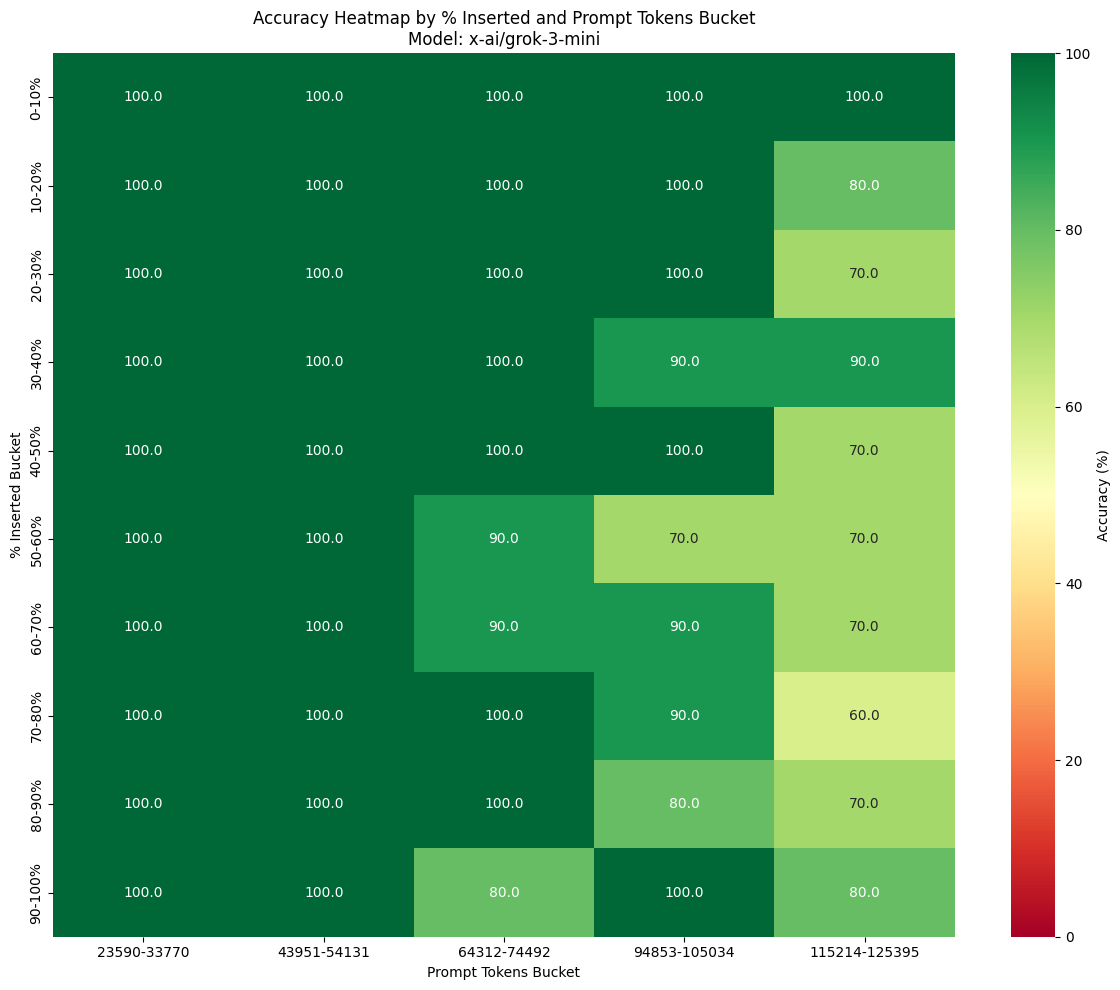


Model: openai/gpt-4.1-nano
Pivot table index (row labels): ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
Pivot table columns (col labels): ['23590-33770', '43951-54131', '64312-74492', '94853-105034', '115214-125395']
percent_inserted_labels: ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
model_prompt_token_labels: ['23590-33770', '43951-54131', '64312-74492', '94853-105034', '115214-125395']
Any non-NaN in heatmap_data? True


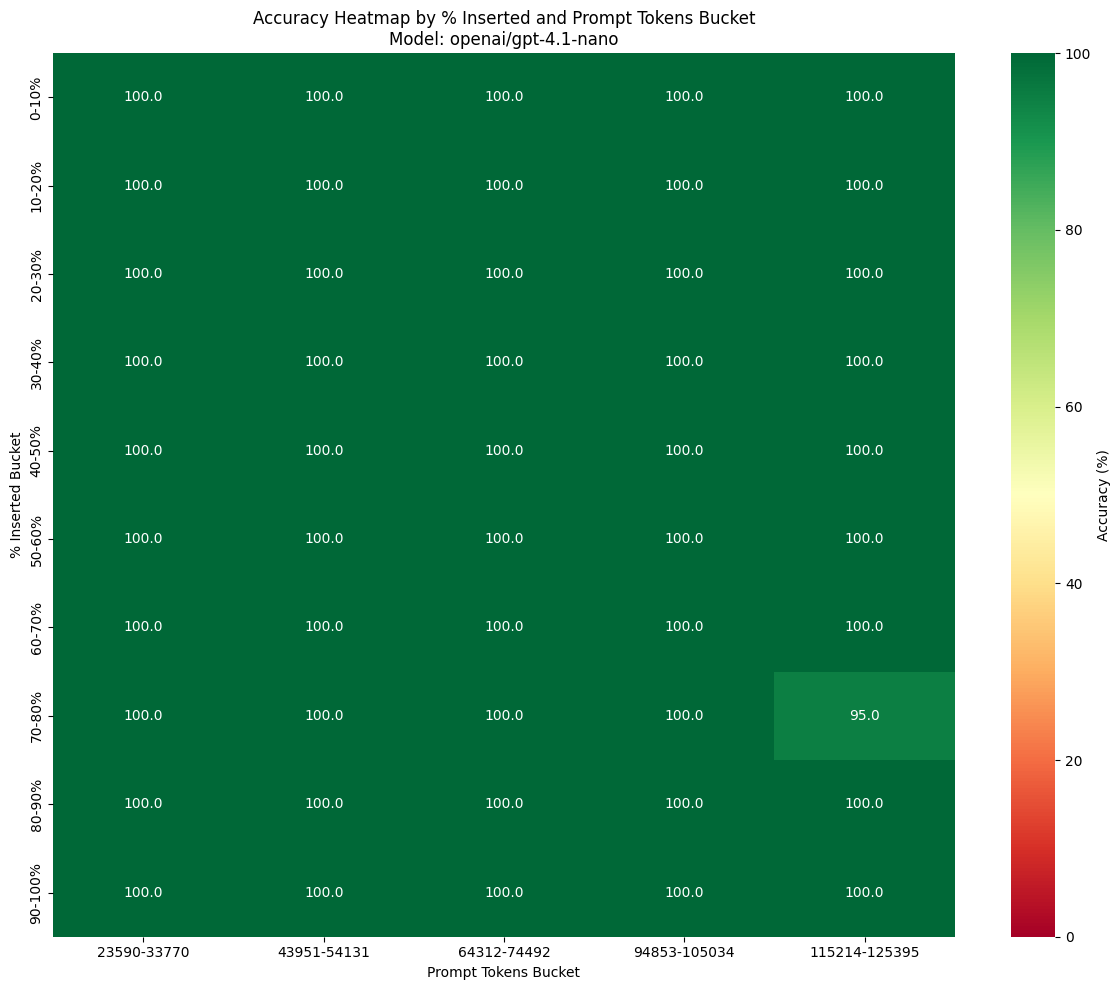


Model: google/gemini-2.5-flash-lite-preview-06-17
Pivot table index (row labels): ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
Pivot table columns (col labels): ['23590-33770', '43951-54131', '74492-84673', '94853-105034', '115214-125395']
percent_inserted_labels: ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
model_prompt_token_labels: ['23590-33770', '43951-54131', '74492-84673', '94853-105034', '115214-125395']
Any non-NaN in heatmap_data? True


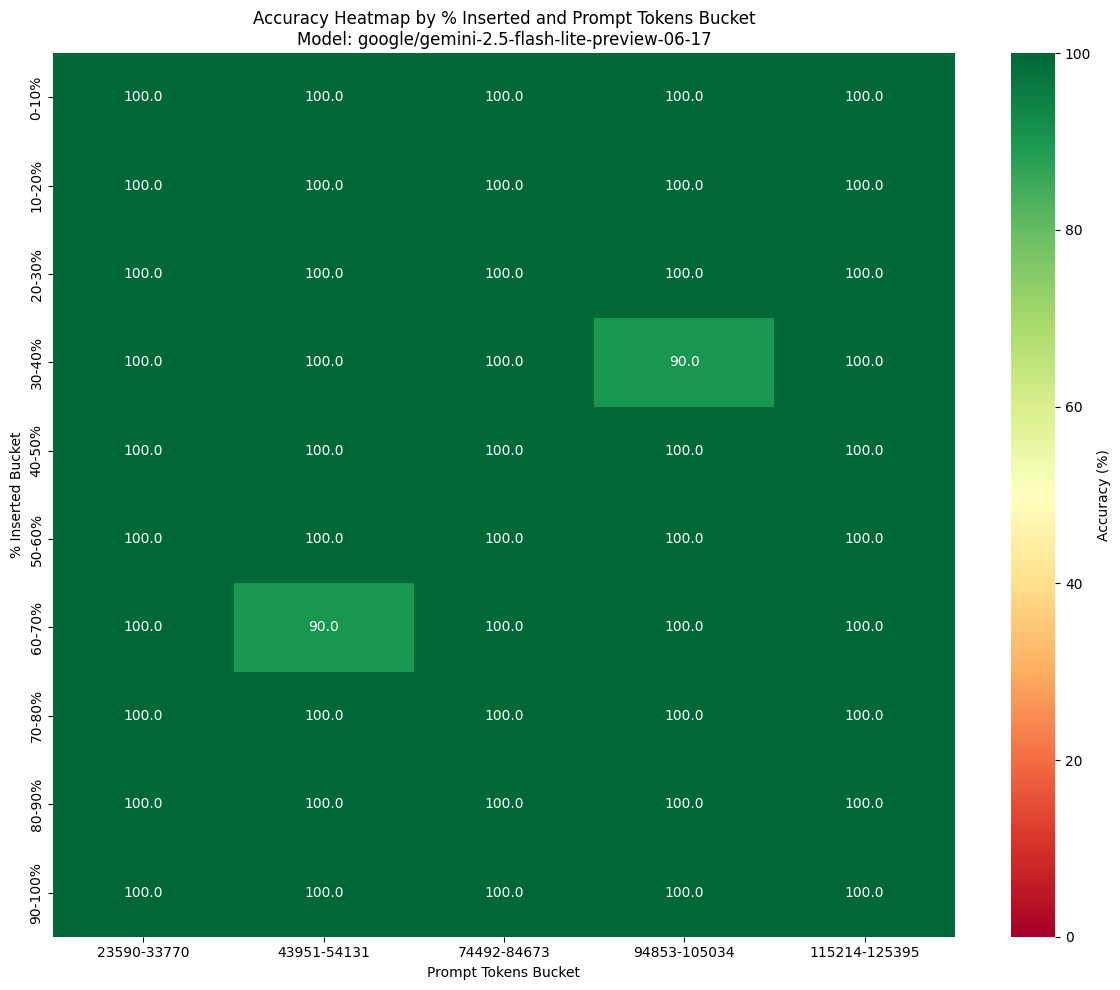

In [161]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# --- Fix for bucket label mismatch and NaN heatmaps ---

# Define the bucket labels for %_inserted_bucket and prompt_tokens_bucket explicitly
percent_inserted_labels = [
    "0-10%", "10-20%", "20-30%", "30-40%", "40-50%",
    "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"
]
# Get prompt_tokens_bucket labels from the DataFrame (they may differ per model)
all_prompt_token_labels = sorted(
    parsed_nith_results_df['prompt_tokens_bucket'].dropna().unique(),
    key=lambda x: float(str(x).split('-')[0])
)

for model_name in parsed_nith_results_df['model'].unique():
    model_df = parsed_nith_results_df[parsed_nith_results_df['model'] == model_name]

    # Get the prompt_tokens_bucket labels present for this model
    model_prompt_token_labels = sorted(
        model_df['prompt_tokens_bucket'].dropna().unique(),
        key=lambda x: float(str(x).split('-')[0])
    )

    # Pivot table: rows = %_inserted_bucket, columns = prompt_tokens_bucket, values = mean accuracy
    heatmap_data = model_df.pivot_table(
        index='%_inserted_bucket',
        columns='prompt_tokens_bucket',
        values='correct',
        aggfunc='mean',
        observed=False  # To silence the FutureWarning and retain current behavior
    )

    # Print for debugging
    print(f"\nModel: {model_name}")
    print("Pivot table index (row labels):", list(heatmap_data.index))
    print("Pivot table columns (col labels):", list(heatmap_data.columns))
    print("percent_inserted_labels:", percent_inserted_labels)
    print("model_prompt_token_labels:", list(model_prompt_token_labels))
    print("Any non-NaN in heatmap_data?", np.any(~np.isnan(heatmap_data.values)))

    # Reindex to ensure all buckets are present and in order
    # Use only the prompt_tokens_bucket labels present in this model's data
    heatmap_data = heatmap_data.reindex(
        index=percent_inserted_labels,
        columns=model_prompt_token_labels
    )

    # If all values are NaN, print a warning and skip plotting
    if heatmap_data.isnull().all().all():
        print(f"WARNING: All values are NaN for model {model_name}. Skipping plot.")
        continue

    plt.figure(figsize=(2 + 2 * len(model_prompt_token_labels), 10))

    sns.heatmap(
        heatmap_data * 100,
        annot=True,
        fmt=".1f",
        cmap="RdYlGn",
        vmin=0,
        vmax=100,
        cbar_kws={'label': 'Accuracy (%)'},
        mask=heatmap_data.isnull()
    )

    plt.ylabel('% Inserted Bucket')
    plt.xlabel('Prompt Tokens Bucket')
    plt.title(f'Accuracy Heatmap by % Inserted and Prompt Tokens Bucket\nModel: {model_name}')
    plt.tight_layout()
    # Save the figure for this model
    safe_model_name = model_name.replace("/", "_").replace(" ", "_")
    plt.savefig(f"accuracy_heatmap_{safe_model_name}.png")
    plt.show()
    plt.close()